# Busca Semântica com Similaridade do Cosseno

Notebook 3 da série: mostra como implementar uma busca vetorial simples usando cosine similarity para priorizar documentos de acordo com o ângulo entre embeddings.


## 1. Introdução
- **Busca semântica** encontra conteúdo relevante mesmo quando a consulta não compartilha termos exatos.
- **Busca literal x vetorial:** literal usa palavras-chave; vetorial compara embeddings (significado) e é robusta a sinônimos/paráfrases.
- **Cosine similarity** é a técnica mais comum porque normaliza vetores e foca no ângulo, ideal para textos de tamanhos diferentes.


## 2. Mini teoria
- **Fórmula:** `cos(a, b) = (a · b) / (||a|| * ||b||)`.
- **Normalização:** dividir cada vetor pela sua norma garante que apenas a direção (ângulo) importe.
- **Por que ângulo > magnitude?** Textos longos podem gerar embeddings com norma maior; cosine corrige esse efeito e privilegia alinhamento semântico.


### Visualização dos ângulos
A ilustração abaixo mostra, em 2D, como vetores com ângulos pequenos (menor que 30°) têm cosine alto, enquanto ângulos maiores indicam menor similaridade.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(11)
plt.style.use("seaborn-v0_8")


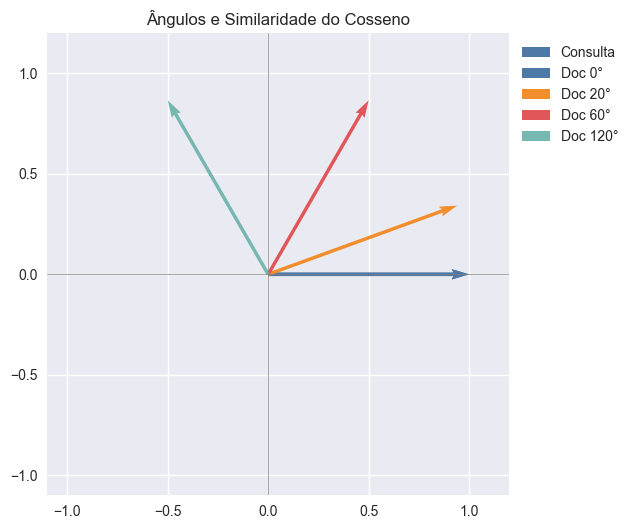

In [2]:
base = np.array([1.0, 0.0])
angles_deg = [0, 20, 60, 120]
colors = ["#4E79A7", "#F28E2B", "#E15759", "#76B7B2"]

fig, ax = plt.subplots(figsize=(6, 6))
ax.quiver(0, 0, base[0], base[1], angles='xy', scale_units='xy', scale=1, color="#4E79A7", label="Consulta")

for angle, color in zip(angles_deg, colors):
    rad = np.deg2rad(angle)
    vec = np.array([np.cos(rad), np.sin(rad)])
    ax.quiver(0, 0, vec[0], vec[1], angles='xy', scale_units='xy', scale=1, color=color, label=f"Doc {angle}°")

ax.set_xlim(-1.1, 1.2)
ax.set_ylim(-1.1, 1.2)
ax.set_aspect('equal')
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)
ax.set_title("Ângulos e Similaridade do Cosseno")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


## 3. Demonstração prática
Vamos criar 5 textos curtos e gerar embeddings simulados (dimensão 4). Em um projeto real usaríamos `sentence-transformers`, mas aqui manteremos simples para focar no cálculo da similaridade.


In [3]:
documents = [
    "Guia rápido de cultivo de café orgânico em casa",
    "Receitas de sobremesas com chocolate amargo",
    "Como escolher o melhor grão para espresso intenso",
    "Cuidados essenciais ao torrar café em pequena escala",
    "Variações de bebidas geladas à base de café"
]

queries = [
    "Qual o melhor grão para espresso?",
    "Como fazer sobremesa com chocolate?"
]

# Embeddings sintéticos (apenas para demonstração)
emb_dim = 4
doc_embeddings = np.abs(np.random.randn(len(documents), emb_dim))
query_embeddings = np.abs(np.random.randn(len(queries), emb_dim))

docs_df = pd.DataFrame(doc_embeddings, columns=[f"dim_{i+1}" for i in range(emb_dim)])
docs_df.insert(0, "documento", documents)
queries_df = pd.DataFrame(query_embeddings, columns=[f"dim_{i+1}" for i in range(emb_dim)])
queries_df.insert(0, "consulta", queries)

docs_df, queries_df


(                                           documento     dim_1     dim_2  \
 0    Guia rápido de cultivo de café orgânico em casa  1.749455  0.286073   
 1        Receitas de sobremesas com chocolate amargo  0.008285  0.319631   
 2  Como escolher o melhor grão para espresso intenso  0.421051  1.065603   
 3  Cuidados essenciais ao torrar café em pequena ...  0.689682  0.561192   
 4        Variações de bebidas geladas à base de café  0.736837  1.574634   
 
       dim_3     dim_4  
 0  0.484565  2.653319  
 1  0.536629  0.315403  
 2  0.886240  0.475733  
 3  1.305549  1.119475  
 4  0.031075  0.683447  ,
                               consulta    dim_1     dim_2     dim_3     dim_4
 0    Qual o melhor grão para espresso?  1.09563  0.309577  0.725752  1.549072
 1  Como fazer sobremesa com chocolate?  0.63008  0.073493  0.732271  0.642575)

## 4. Implementação Python
Passos: (1) normalizar embeddings, (2) calcular cosine similarity manualmente, (3) criar função de busca.


In [11]:
def normalize_rows(matrix: np.ndarray) -> np.ndarray:
    norms = np.linalg.norm(matrix, axis=1, keepdims=True)
    norms[norms == 0] = 1e-9
    return matrix / norms


norm_docs = normalize_rows(doc_embeddings)
norm_queries = normalize_rows(query_embeddings)

norm_docs[:2], norm_queries[:1]


(array([[0.54203141, 0.08863364, 0.15013222, 0.82207442],
        [0.01183902, 0.45676412, 0.76686166, 0.45072117]]),
 array([[0.53318115, 0.15065348, 0.35318265, 0.75384575]]))

In [15]:
def cosine_similarity_matrix(query_matrix: np.ndarray, doc_matrix: np.ndarray) -> np.ndarray:
    return query_matrix @ doc_matrix.T


similarity = cosine_similarity_matrix(norm_queries, norm_docs)
similarity_df = pd.DataFrame(similarity, index=queries, columns=documents)
similarity_df


,Guia rápido de cultivo de café orgânico em casa,Receitas de sobremesas com chocolate amargo,Como escolher o melhor grão para espresso intenso,Cuidados essenciais ao torrar café em pequena escala,Variações de bebidas geladas à base de café
Qual o melhor grão para espresso?,0.975095,0.685742,0.693059,0.907664,0.618901
Como fazer sobremesa com chocolate?,0.848323,0.767451,0.732463,0.955751,0.479708


In [9]:
def search(query_idx: int, top_k: int = 3) -> pd.DataFrame:
    sims = similarity[query_idx]
    ranking = (
        pd.DataFrame({"documento": documents, "cosine_similarity": sims})
        .sort_values(by="cosine_similarity", ascending=False)
        .head(top_k)
        .reset_index(drop=True)
    )
    ranking.insert(0, "consulta", queries[query_idx])
    return ranking

search(0, top_k=3)


,consulta,documento,cosine_similarity
0,Qual o melhor grão para espresso?,Guia rápido de cultivo de café orgânico em casa,0.975095
1,Qual o melhor grão para espresso?,Cuidados essenciais ao torrar café em pequena ...,0.907664
2,Qual o melhor grão para espresso?,Como escolher o melhor grão para espresso intenso,0.693059


In [10]:
for idx in range(len(queries)):
    display(search(idx, top_k=3))


,consulta,documento,cosine_similarity
0,Qual o melhor grão para espresso?,Guia rápido de cultivo de café orgânico em casa,0.975095
1,Qual o melhor grão para espresso?,Cuidados essenciais ao torrar café em pequena ...,0.907664
2,Qual o melhor grão para espresso?,Como escolher o melhor grão para espresso intenso,0.693059


,consulta,documento,cosine_similarity
0,Como fazer sobremesa com chocolate?,Cuidados essenciais ao torrar café em pequena ...,0.955751
1,Como fazer sobremesa com chocolate?,Guia rápido de cultivo de café orgânico em casa,0.848323
2,Como fazer sobremesa com chocolate?,Receitas de sobremesas com chocolate amargo,0.767451


In [ ]:
plt.figure(figsize=(8, 4))
sns.heatmap(similarity_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Heatmap de Similaridade (Cosine)")
plt.ylabel("Consultas")
plt.xlabel("Documentos")
plt.show()


> **Interpretação:** valores próximos de 1 indicam alto alinhamento semântico entre consulta e documento. Como normalizamos os vetores, textos longos não dominam o ranking apenas pelo tamanho.


## 5. Simulação pgvector (SQL)
Exemplo de como salvar embeddings e consultar usando cosine similarity no Postgres com pgvector.


```sql
-- 1. Tabela para mensagens / documentos
CREATE TABLE kb_messages (
    id SERIAL PRIMARY KEY,
    titulo TEXT,
    conteudo TEXT,
    embedding vector(768)
);

-- 2. Índice HNSW para cosine (vector_cosine_ops)
CREATE INDEX kb_messages_embedding_hnsw
ON kb_messages
USING hnsw (embedding vector_cosine_ops);

-- 3. Query de busca semântica usando operador <=> (cosine distance)
WITH query AS (
  SELECT '[0.12, 0.03, ..., 0.05]'::vector AS embedding -- embedding gerado na aplicação
)
SELECT m.id, m.titulo, m.embedding <=> query.embedding AS distance
FROM kb_messages m, query
ORDER BY distance ASC
LIMIT 5;
```



## 6. Como escalar
- **Chunking de texto:** divida documentos longos em partes menores (ex.: 500 palavras) para melhorar recall.
- **Dimensão dos vetores:** modelos maiores (768, 1024, 1536+) capturam mais nuance, mas aumentam custo.
- **Tamanho do banco:** escolha índices ANN adequados (IVFFlat/HNSW); monitore `lists`, `ef_search`.
- **Re-ranking:** após a busca vetorial, reordene com modelos menores (ex.: cross-encoder) ou sinais adicionais (popularidade, data).


### Exemplo simples de chunking
```text
Documento longo → [parágrafo 1], [parágrafo 2], ...
Cada chunk recebe um embedding próprio e herda metadados (ID do documento, seção, etc.).
Na busca, retornamos o chunk mais relevante e opcionalmente agregamos ao documento original.
```


## 7. Conclusão
- Cosine similarity padroniza comparações entre textos de tamanhos distintos.
- Busca semântica melhora experiências de FAQ, suporte, documentação e discovery.
- pgvector oferece operador `<=>` e índices ANN otimizados para cosine.
- Próximo notebook: distância euclidiana aplicada a agrupamentos e restrições rígidas.
